# Modifications de résultats des sondages

## Import préliminaires des librairies

In [1]:
%pylab inline
# Command OS
import os

# Regex
import re

# Calcul and data manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import seaborn as sns

# Dealing with specific representation of number
# Aka commat in french in numbers
import locale
from locale import atof





Populating the interactive namespace from numpy and matplotlib


## Import du dataframe

## Calcul de l'erreur à 95% de confiance

In [2]:
def error_p(p,n=1000,Za=1.96):
    return np.sqrt(p*(1-p)/n)*Za
error_p(0.48,300)

0.05653504399927535

## Calcul de l'intervalle de confiance

In [3]:
def margin_p(p,n=1000,Za=1.96):
    er=error_p(p,n,Za)
    return np.array([p-er,p+er])


In [4]:
def error_in_margin(p,n,variation,Za=1.96,double_margin=True):
    # Compute old values
    old_p=p-variation
    # Compute err
    err=error_p(p/100,n,Za)*100
    # Compute err old values
    old_err=error_p(old_p/100,n,Za)*100
    if double_margin:
        return (np.abs(variation)<=err+old_err) & variation!=0
    else:
        return (np.abs(variation)<=err) & variation!=0


In [5]:
def extract_in_margin(fav,defav,evol_fav,evol_defav,pop_size,double_margin=True):
    # Suppression des valeurs sans variation
    fav=fav[evol_fav!=0]
    defav=defav[evol_defav!=0]
    pop_size_fav=pop_size[evol_fav!=0]
    pop_size_defav=pop_size[evol_defav!=0]
    evol_fav=evol_fav[evol_fav!=0]
    evol_defav=evol_defav[evol_defav!=0]

    # Calcul des erreurs
    err_fav=error_p(fav/100,pop_size_fav)*100
    err_defav=error_p(defav/100,pop_size_defav)*100

    # Calcul des anciennes valeurs
    old_fav=fav-evol_fav
    old_defav=defav-evol_defav
    # Calcul des erreurs anciennes valeurs
    err_old_fav=error_p(old_fav/100,pop_size_fav)*100
    err_old_defav=error_p(old_defav/100,pop_size_defav)*100
    if double_margin:
        total_fav_in_margin=np.sum(err_fav+err_old_fav>=np.abs(evol_fav))
        total_defav_in_margin=np.sum(err_defav+err_old_defav>=np.abs(evol_defav))
    else:
        total_fav_in_margin=np.sum(err_fav>=np.abs(evol_fav))
        total_defav_in_margin=np.sum(err_defav>=np.abs(evol_defav))
    total_in_margin=total_fav_in_margin+total_defav_in_margin
    total_lines=len(fav)+len(defav)

    return (total_in_margin,total_lines)

In [6]:
filenames=[f.rstrip('.p') for f in os.listdir('data')]
sum_in_margin=0
total_lines=0
df=pd.read_pickle("data/2020-03-20.p")
data_f=pd.DataFrame(columns=df.columns)
for fn in filenames:
    df=pd.read_pickle("data/{}.p".format(fn))
    df.Base=df.Base.astype('float')
    df['Date']=fn
    data_f=pd.concat([data_f,df])
    in_margin,nb_lines=extract_in_margin(df['ST Favorable'],df['ST Défavorable'],df['Evolution ST Favorable'],df['Evolution ST Défavorable'],df.Base)
    sum_in_margin+=in_margin
    total_lines+=nb_lines
data_f.Date=data_f.Date.astype('datetime64')
print(sum_in_margin/total_lines)



0.9603042479908152


In [7]:
Nom ='Edouard PHILIPPE'
d_margin_err=True

data_f['Inexploitable Favorable']=error_in_margin(data_f['ST Favorable'],data_f["Base"],data_f['Evolution ST Favorable'],double_margin=d_margin_err)
data_f['Inexploitable Défavorable']=error_in_margin(data_f['ST Défavorable'],data_f["Base"],data_f['Evolution ST Défavorable'],double_margin=d_margin_err)
data_f['Erreur Th Favorable']=error_p(data_f['ST Favorable']/100,data_f["Base"])*100
data_f['Erreur Th Défavorable']=error_p(data_f['ST Défavorable']/100,data_f["Base"],)*100
data_f['Inexploitable Favorable'].value_counts()
data_f['Inexploitable Défavorable'].value_counts()
df_inex=pd.DataFrame()
df_inex['Résultats']=pd.concat([data_f['ST Favorable'],data_f['ST Défavorable']])
df_inex['Categorie']=pd.concat([data_f['Categorie'],data_f['Categorie']])
df_inex['Inexploitable']=pd.concat([data_f['Inexploitable Favorable'],data_f['Inexploitable Défavorable']])
df_inex['Nom']=pd.concat([data_f['Nom'],data_f['Nom']])
groupe=df_inex[df_inex.Categorie=='ENSEMBLE']

data_f[data_f.Nom==Nom]


,Nom,Categorie,Groupe,Base,Très favorable,Plutôt favorable,ST Favorable,Plutôt défavorable,Très défavorable,ST Défavorable,Nsp,Evolution ST Favorable,Evolution ST Défavorable,Date,Inexploitable Favorable,Inexploitable Défavorable,Erreur Th Favorable,Erreur Th Défavorable
70,Edouard PHILIPPE,ENSEMBLE,ENSEMBLE,971.0,3.6,26.3,30.0,29.1,17.2,46.3,23.8,1.4,-2.5,2018-12-08,True,True,2.882412,3.136347
71,Edouard PHILIPPE,Sexe,Homme,462.0,5.2,29.7,34.9,31.6,19.4,51.0,14.1,1.7,-1.1,2018-12-08,True,True,4.346486,4.558461
72,Edouard PHILIPPE,Sexe,Femme,509.0,2.2,23.3,25.5,26.8,15.2,42.0,32.5,1.1,-3.8,2018-12-08,True,True,3.786565,4.287813
73,Edouard PHILIPPE,Age,18 à 24 ans,103.0,7.5,14.8,22.3,22.8,10.9,33.8,44.0,3.4,-0.9,2018-12-08,True,True,8.038970,9.135342
74,Edouard PHILIPPE,Age,25 à 34 ans,154.0,0.2,13.1,13.3,26.2,18.2,44.4,42.3,-8.9,-3.2,2018-12-08,True,True,5.363288,7.847378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2375,Edouard PHILIPPE,VotePrésidentielle20171ertour,STNonexpr,238.0,9.3,34.1,43.4,21.9,16.7,38.7,17.9,1.3,5.0,2021-01-22,True,True,6.296811,6.188043
2376,Edouard PHILIPPE,VotePrésidentielle20172ndtour,EmmanuelMacron,410.0,24.2,41.7,65.9,18.3,9.8,28.1,6.0,-7.0,5.1,2021-01-22,True,True,4.588641,4.350927
2377,Edouard PHILIPPE,VotePrésidentielle20172ndtour,MarineLePen,210.0,8.5,28.9,37.4,26.0,27.8,53.8,8.8,-8.0,6.6,2021-01-22,True,True,6.544393,6.743084
2378,Edouard PHILIPPE,VotePrésidentielle20172ndtour,STExpr,620.0,18.9,37.4,56.2,20.9,15.9,36.8,6.9,-7.3,5.6,2021-01-22,True,True,3.905399,3.796144


## Inexploitable global

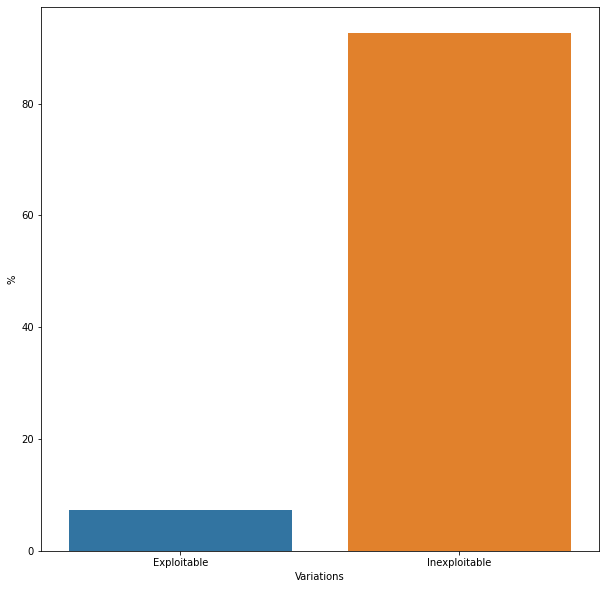

In [8]:
fig = plt.figure(figsize=(10,10))
ax=sns.barplot(x='Inexploitable', y='Inexploitable', data=df_inex, estimator=lambda x: len(x) / len(df_inex) * 100)
ax.set(ylabel="%")
ax.set(xlabel="Variations")
ax.set(xticklabels=['Exploitable', 'Inexploitable'])
# ax.yaxis.set_major_locator(ticker.MultipleLocator(2))

fig.savefig('plot.svg')

In [9]:
print(df_inex.Inexploitable.value_counts())
df_inex.Inexploitable.value_counts()/len(df_inex)

True     66914
False     5326
Name: Inexploitable, dtype: int64


True     0.926274
False    0.073726
Name: Inexploitable, dtype: float64

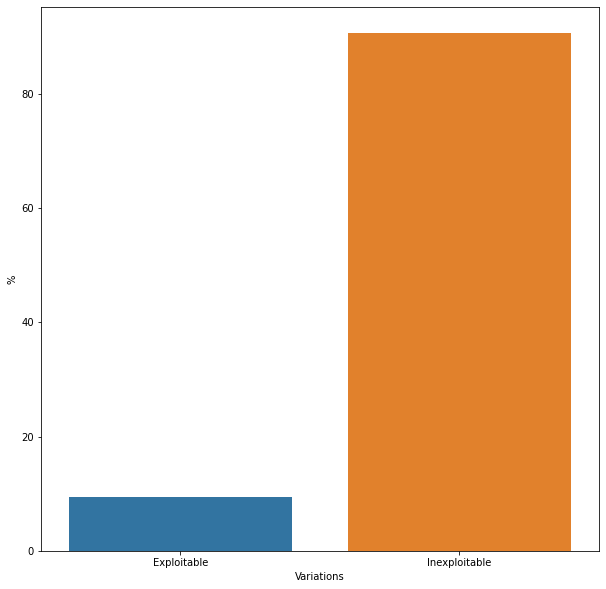

In [10]:
df_inex_ens=df_inex[df_inex.Categorie=='ENSEMBLE']
fig = plt.figure(figsize=(10,10))
ax=sns.barplot(x='Inexploitable', y='Inexploitable', data=df_inex_ens, estimator=lambda x: len(x) / len(df_inex_ens) * 100)
ax.set(ylabel="%")
ax.set(xlabel="Variations")
ax.set(xticklabels=['Exploitable', 'Inexploitable'])
# ax.yaxis.set_major_locator(ticker.MultipleLocator(2))

fig.savefig('plot.svg')


In [11]:
print(df_inex_ens.Inexploitable.value_counts())
df_inex_ens.Inexploitable.value_counts()/len(df_inex_ens)

True     935
False     97
Name: Inexploitable, dtype: int64


True     0.906008
False    0.093992
Name: Inexploitable, dtype: float64

## Inexploitable sur groupe ENSEMBLE (seulement tous les sondés)

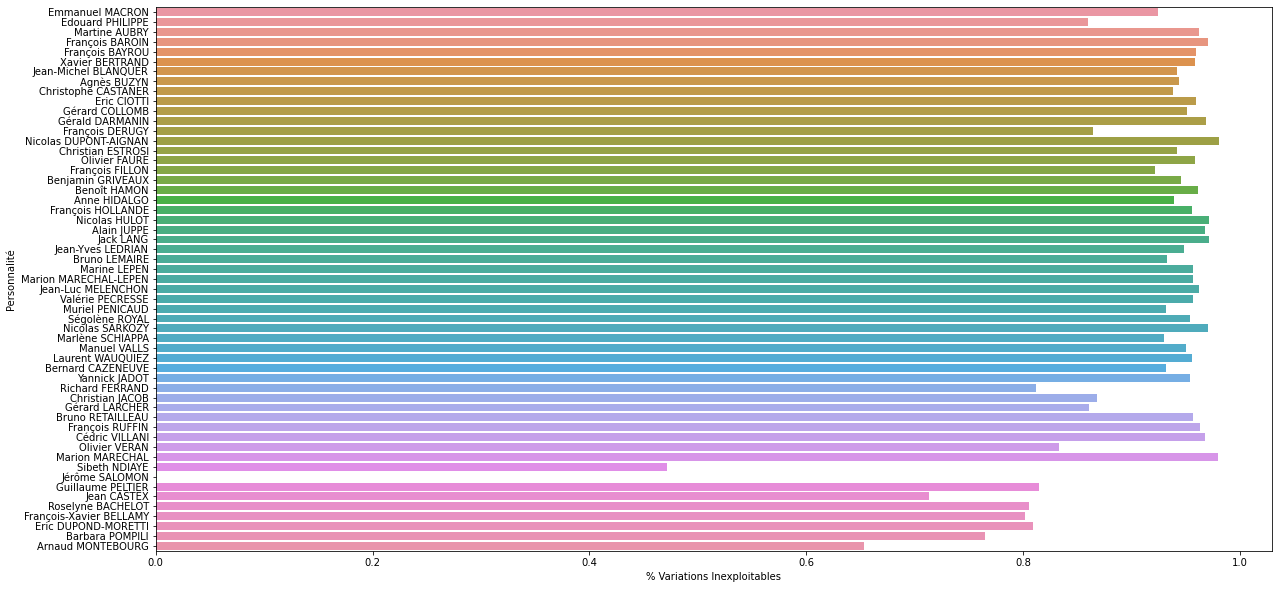

In [12]:
fig = plt.figure(figsize=(20,10))
ax=sns.barplot(x='Inexploitable',y='Nom',data=df_inex,ci=None
#  ,estimator=lambda x: len(x) / len(df_inex[df_inex.Categorie=='ENSEMBLE']) * 100
)
ax.set(xlabel="% Variations Inexploitables")
ax.set(ylabel="Personnalité ")
# ax.yaxis.set_major_locator(ticker.MultipleLocator(2))

fig.savefig('plot.png')

In [13]:
print(groupe['Inexploitable'].value_counts()/len(groupe))
print(groupe['Inexploitable'].value_counts())
# data_f['Inexploitable Défavorable'].value_counts()

True     0.906008
False    0.093992
Name: Inexploitable, dtype: float64
True     935
False     97
Name: Inexploitable, dtype: int64


## Inexploitable sur toutes les variations

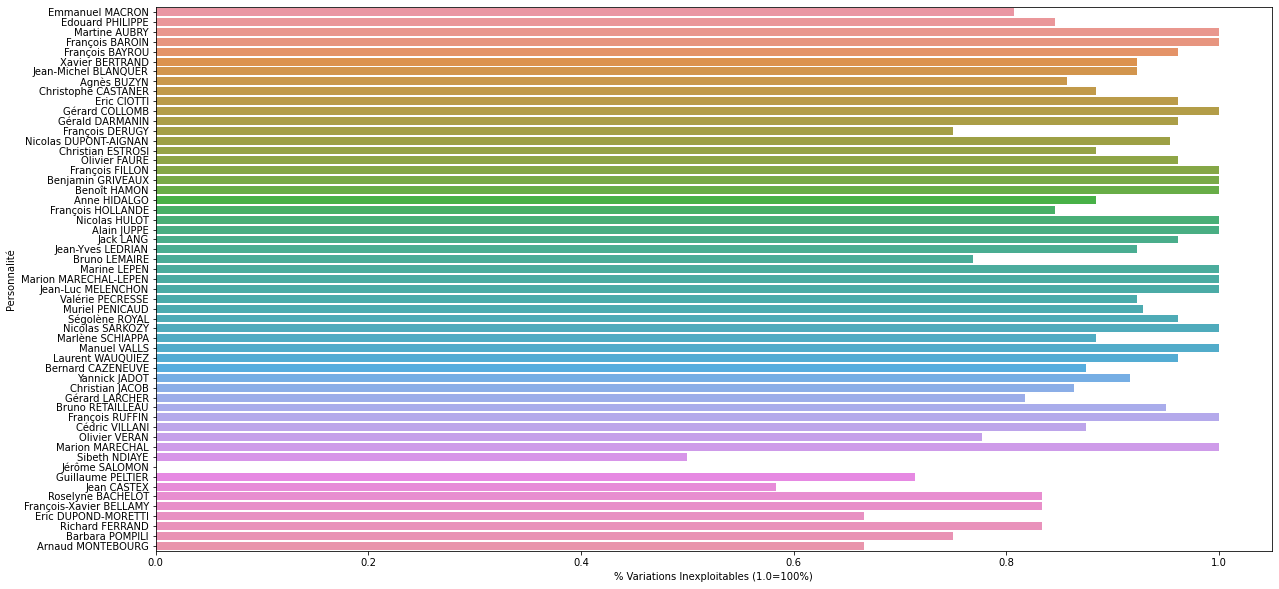

In [14]:
fig = plt.figure(figsize=(20,10))
ax=sns.barplot(x='Inexploitable',y='Nom',data=groupe,ci=None
#  ,estimator=lambda x: len(x) / len(df_inex[df_inex.Categorie=='ENSEMBLE']) * 100
)
ax.set(xlabel="% Variations Inexploitables (1.0=100%)")
ax.set(ylabel="Personnalité ")
# ax.yaxis.set_major_locator(ticker.MultipleLocator(2))

fig.savefig('plot.png')

In [15]:
print(df_inex['Inexploitable'].value_counts()/len(df_inex))
print(df_inex['Inexploitable'].value_counts())

True     0.926274
False    0.073726
Name: Inexploitable, dtype: float64
True     66914
False     5326
Name: Inexploitable, dtype: int64


## Taille échantillons groupes de gauche

In [16]:
data_f[data_f.Categorie=='Proximitépolitique'].Groupe.value_counts()

DLF                              516
PS                               516
MoDem                            516
LREM                             516
UDI                              516
LR                               516
EELV                             516
RN                               516
STDroite(LRUDI)                  480
STCentre(ModemLREM)              480
STGauche(FIPdGPCPSEELV)          480
STFIPdGPC                        480
Aucunparti                       480
Aucun parti                       36
ST Gauche (FI PdG PC PS EELV)     36
ST FI PdG PC                      36
ST Droite (LR UDI)                36
ST Centre (Modem LREM)            36
Name: Groupe, dtype: int64

In [17]:
filtre_soutien_gauche= (data_f.Groupe == 'PS') | (data_f.Groupe == 'EELV') | (data_f.Groupe == 'STFIPdGPC') # | (data_f.Groupe == 'STGauche(FIPdGPCPSEELV)') 
filtre_soutien_gauche_full= (data_f.Groupe == 'PS') | (data_f.Groupe == 'EELV') | (data_f.Groupe == 'STFIPdGPC')  | (data_f.Groupe == 'STGauche(FIPdGPCPSEELV)') 
taille_gauche_full=data_f[filtre_soutien_gauche_full][['Base','Date','Groupe']]
# test_df=taille_gauche_full=data_f[filtre_soutien_gauche_full][['Base','Date','Groupe']].pivot_table(values='Base',index=['Date'],columns=['Groupe'])
taille_gauche_detail=data_f[filtre_soutien_gauche][['Base','Date','Groupe']].pivot_table(values='Base',index=['Date'],columns=['Groupe'])
taille_gauche_detail.rename(columns={'STFIPdGPC':'FI-PdG-PC'}, inplace=True)
taille_gauche_detail=taille_gauche_detail[['FI-PdG-PC','PS','EELV']]
taille_gauche_full.replace('STFIPdGPC','FI-PdG-PC',inplace=True)
taille_gauche_full.replace('STGauche(FIPdGPCPSEELV)','Soutien Gauche (Total)',inplace=True)

### Plot stack

(0.0, 350.0)

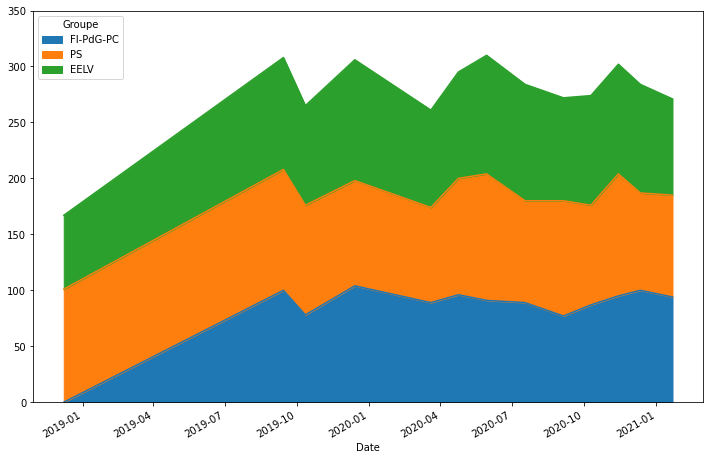

In [18]:

# fig = plt.figure(figsize=(12,8))
# ax=sns.lineplot(data=taille_gauche_detail,x='Date',y='Base',hue='Groupe')
# ax=sns.lineplot(data=taille_echantillon_gauche,x='Date',y='Base')

ax=taille_gauche_detail.plot.area(figsize=(12,8))
taille_gauche_detail
ax.set_ylim(0,350)

### Plot line

In [19]:
taille_gauche_full["Erreur"]=error_p(taille_gauche_full.Base/1000,1000)*1000


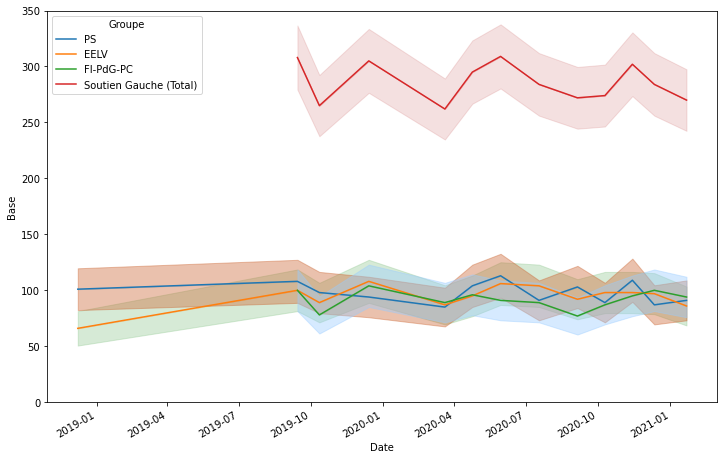

In [20]:
# years = mdates.YearLocator()   # every year
# months = mdates.MonthLocator()  # every month
# years_fmt = mdates.DateFormatter('%m-%Y')

fig = plt.figure(figsize=(12,8))
# ax=sns.lineplot(data=taille_gauche_detail,x='Date',y='Base',hue='Groupe')
ax=sns.lineplot(data=taille_gauche_full,x='Date',y='Base',hue='Groupe',err_style='band')
ax.set_ylim(0,350)

# # format the ticks
# ax.xaxis.set_major_locator(months)
# ax.xaxis.set_major_formatter(years_fmt)
# # ax.xaxis.set_minor_locator(months)

# # round to nearest years.
# datemin = np.datetime64(taille_gauche_full.Date.min())
# datemax = np.datetime64(taille_gauche_full.Date.max())
# ax.set_xlim(datemin, datemax)
# ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')

# Organise date on ticks automatically
fig.autofmt_xdate()

total_gauche=taille_gauche_full[taille_gauche_full.Groupe=="Soutien Gauche (Total)"]
EELV=taille_gauche_full[taille_gauche_full.Groupe=="EELV"]
PS=taille_gauche_full[taille_gauche_full.Groupe=="PS"]
FI=taille_gauche_full[taille_gauche_full.Groupe=="FI-PdG-PC"]

plt.fill_between(total_gauche.Date, total_gauche.Base-total_gauche.Erreur, total_gauche.Base+total_gauche.Erreur,color='#cc6666', alpha=.2)
plt.fill_between(EELV.Date, EELV.Base-EELV.Erreur, EELV.Base+EELV.Erreur,color='#99cc99', alpha=.4)
plt.fill_between(PS.Date, PS.Base-PS.Erreur, PS.Base+PS.Erreur,color='#cc6633', alpha=.4)
plt.fill_between(FI.Date, FI.Base-FI.Erreur, FI.Base+FI.Erreur,color='#99ccff', alpha=.4)


# Variations personnalité

In [21]:
print(data_f.Categorie.value_counts())
data_f[data_f.Categorie=='Proximitépolitique'].Groupe.value_counts()

Proximitépolitique                   6708
Age                                  4644
PCSdelapersonnederéférencedufoyer    4129
PCSdel'individu                      4127
VotePrésidentielle20171ertour        3612
Région                               3096
Catégoried'agglomération             2580
Revenumensuelnetdufoyer              2064
VotePrésidentielle20172ndtour        2064
Diplômeleplusélevé                   1440
Sexe                                 1032
ENSEMBLE                              516
Niveaud'études                        108
Name: Categorie, dtype: int64


DLF                              516
PS                               516
MoDem                            516
LREM                             516
UDI                              516
LR                               516
EELV                             516
RN                               516
STDroite(LRUDI)                  480
STCentre(ModemLREM)              480
STGauche(FIPdGPCPSEELV)          480
STFIPdGPC                        480
Aucunparti                       480
Aucun parti                       36
ST Gauche (FI PdG PC PS EELV)     36
ST FI PdG PC                      36
ST Droite (LR UDI)                36
ST Centre (Modem LREM)            36
Name: Groupe, dtype: int64

In [22]:
nom='Jean CASTEX'
data_pers=data_f[(data_f.Nom==nom) & (data_f.Groupe=='ENSEMBLE')]
data_pers['Erreur favorable']=error_p(data_pers['ST Favorable']/100,data_pers.Base)*100
data_pers['Erreur défavorable']=error_p(data_pers['ST Défavorable']/100,data_pers.Base)*100
data_pers

,Nom,Categorie,Groupe,Base,Très favorable,Plutôt favorable,ST Favorable,Plutôt défavorable,Très défavorable,ST Défavorable,Nsp,Evolution ST Favorable,Evolution ST Défavorable,Date,Inexploitable Favorable,Inexploitable Défavorable,Erreur Th Favorable,Erreur Th Défavorable,Erreur favorable,Erreur défavorable
70,Jean CASTEX,ENSEMBLE,ENSEMBLE,1000.0,4.8,27.9,32.7,15.8,11.5,27.3,39.9,0.0,0.0,2020-07-18,False,False,2.907619,2.761243,2.907619,2.761243
70,Jean CASTEX,ENSEMBLE,ENSEMBLE,1000.0,4.0,32.9,37.0,23.0,18.0,41.0,22.0,4.2,13.7,2020-09-05,True,False,2.992452,3.048414,2.992452,3.048414
70,Jean CASTEX,ENSEMBLE,ENSEMBLE,1000.0,3.4,31.6,35.0,30.4,18.2,48.6,16.4,-2.0,7.6,2020-10-10,True,False,2.956288,3.097817,2.956288,3.097817
70,Jean CASTEX,ENSEMBLE,ENSEMBLE,1000.0,2.9,28.5,31.4,33.4,26.7,60.1,8.5,-3.6,11.4,2020-11-14,True,False,2.876623,3.035147,2.876623,3.035147
70,Jean CASTEX,ENSEMBLE,ENSEMBLE,1000.0,3.1,32.9,36.0,29.7,27.3,57.0,6.9,4.6,-3.0,2020-12-12,True,True,2.975071,3.068511,2.975071,3.068511
70,Jean CASTEX,ENSEMBLE,ENSEMBLE,1000.0,3.4,28.3,31.7,34.3,27.0,61.3,7.0,-4.3,4.3,2021-01-22,True,True,2.884005,3.018852,2.884005,3.018852


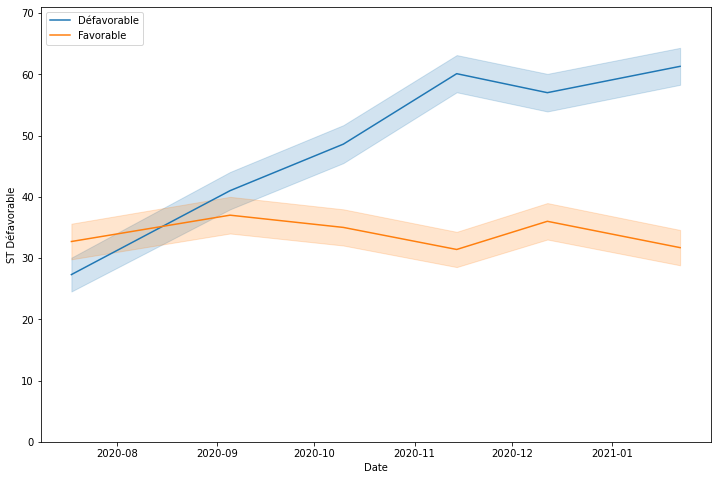

In [23]:


fig = plt.figure(figsize=(12,8))
# ax=sns.lineplot(data=taille_gauche_detail,x='Date',y='Base',hue='Groupe')

ax=sns.lineplot(data=data_pers,x='Date',y='ST Défavorable',label='Défavorable')
current_color=ax.get_lines()[0].get_color()
plt.fill_between(data_pers.Date, data_pers['ST Défavorable']-data_pers['Erreur défavorable'], data_pers['ST Défavorable']+data_pers['Erreur défavorable'],color=current_color, alpha=.2)

sns.lineplot(data=data_pers,x='Date',y='ST Favorable',label='Favorable')
current_color=ax.get_lines()[1].get_color()
plt.fill_between(data_pers.Date, data_pers['ST Favorable']-data_pers['Erreur favorable'], data_pers['ST Favorable']+data_pers['Erreur favorable'],color=current_color, alpha=.2)

# Organise date on ticks automatically
# fig.autofmt_xdate()
ax.set_ylim(0,int(np.max([data_pers['ST Favorable'].max(),data_pers['ST Défavorable'].max()]))+10)
plt.legend(loc='upper left')

# Analyse du dernier rapport

In [24]:
all_dates=np.sort(data_f.Date.unique())
most_recent=all_dates[-1]
scd_most_recent=all_dates[-2]

In [50]:
last_data=data_f[data_f.Date==data_f.Date.max()]
last_inex=pd.DataFrame()
last_inex['Résultats']=pd.concat([last_data['ST Favorable'],last_data['ST Défavorable']])
last_inex['Categorie']=pd.concat([last_data['Categorie'],last_data['Categorie']])
last_inex['Groupe']=pd.concat([last_data['Groupe'],last_data['Groupe']])
last_inex['Inexploitable']=pd.concat([last_data['Inexploitable Favorable'],last_data['Inexploitable Défavorable']])
last_inex['Nom']=pd.concat([last_data['Nom'],last_data['Nom']])
last_inex

,Résultats,Categorie,Groupe,Inexploitable,Nom
0,35.1,ENSEMBLE,ENSEMBLE,True,Emmanuel MACRON
1,37.1,Sexe,Homme,True,Emmanuel MACRON
2,33.3,Sexe,Femme,True,Emmanuel MACRON
3,45.4,Age,18à24ans,True,Emmanuel MACRON
4,37.1,Age,25à34ans,True,Emmanuel MACRON
...,...,...,...,...,...
2935,43.5,VotePrésidentielle20171ertour,STNonexpr,True,Laurent WAUQUIEZ
2936,61.5,VotePrésidentielle20172ndtour,EmmanuelMacron,True,Laurent WAUQUIEZ
2937,48.0,VotePrésidentielle20172ndtour,MarineLePen,True,Laurent WAUQUIEZ
2938,56.9,VotePrésidentielle20172ndtour,STExpr,True,Laurent WAUQUIEZ


## Inexploitables global

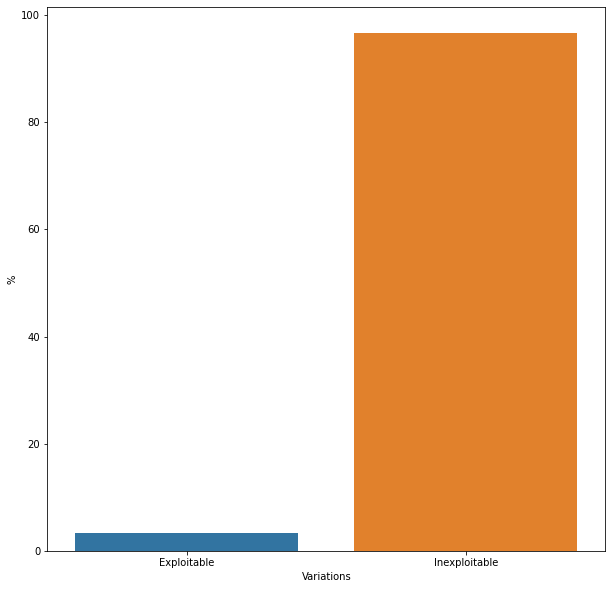

In [45]:
fig = plt.figure(figsize=(10,10))
ax=sns.barplot(x='Inexploitable', y='Inexploitable', data=last_inex, estimator=lambda x: len(x) / len(last_inex) * 100)
ax.set(ylabel="%")
ax.set(xlabel="Variations")
ax.set(xticklabels=['Exploitable', 'Inexploitable'])
# ax.yaxis.set_major_locator(ticker.MultipleLocator(2))

fig.savefig('plot.png')

In [27]:
print(last_inex.Inexploitable.value_counts())
last_inex.Inexploitable.value_counts()/len(last_inex)

True     5683
False     197
Name: Inexploitable, dtype: int64


True     0.966497
False    0.033503
Name: Inexploitable, dtype: float64

## Inexploitable par personnalité

### Inexploitable sur tout le jeu de données

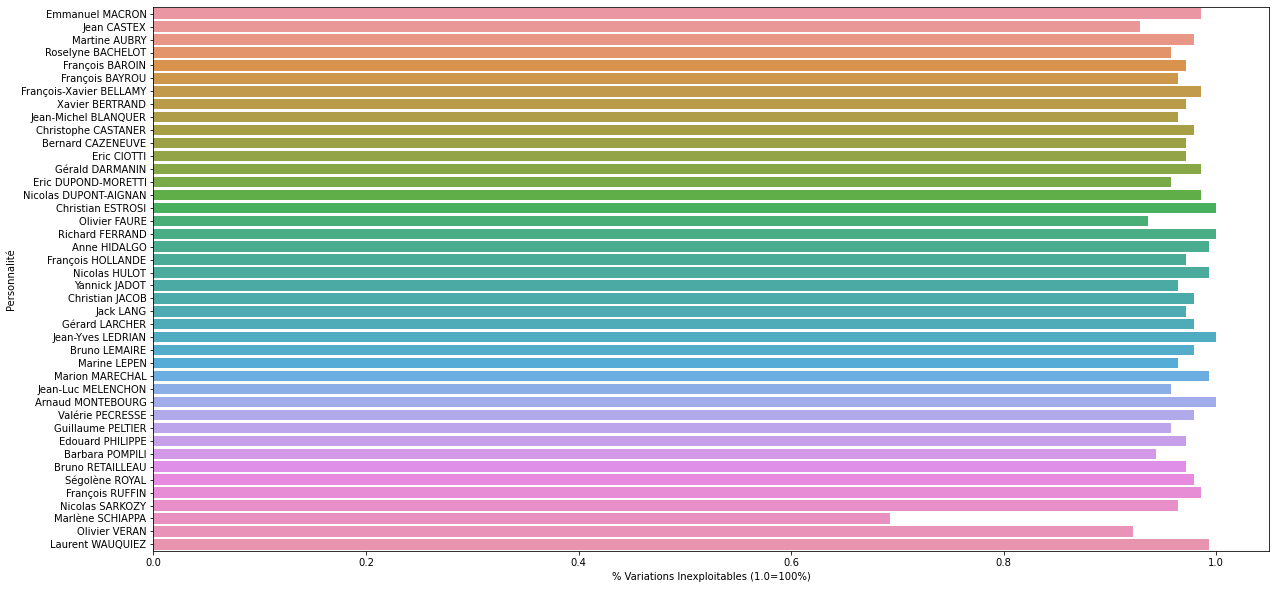

In [46]:
fig = plt.figure(figsize=(20,10))
ax=sns.barplot(x='Inexploitable',y='Nom',data=last_inex,ci=None
#  ,estimator=lambda x: len(x) / len(df_inex[df_inex.Categorie=='ENSEMBLE']) * 100
)
ax.set(xlabel="% Variations Inexploitables (1.0=100%)")
ax.set(ylabel="Personnalité ")
# ax.yaxis.set_major_locator(ticker.MultipleLocator(2))

fig.savefig('plot.png')

In [29]:
print(last_inex['Inexploitable'].value_counts()/len(last_inex))
print(last_inex['Inexploitable'].value_counts())

True     0.966497
False    0.033503
Name: Inexploitable, dtype: float64
True     5683
False     197
Name: Inexploitable, dtype: int64


### Inexploitable sur le groupe ENSEMBLE

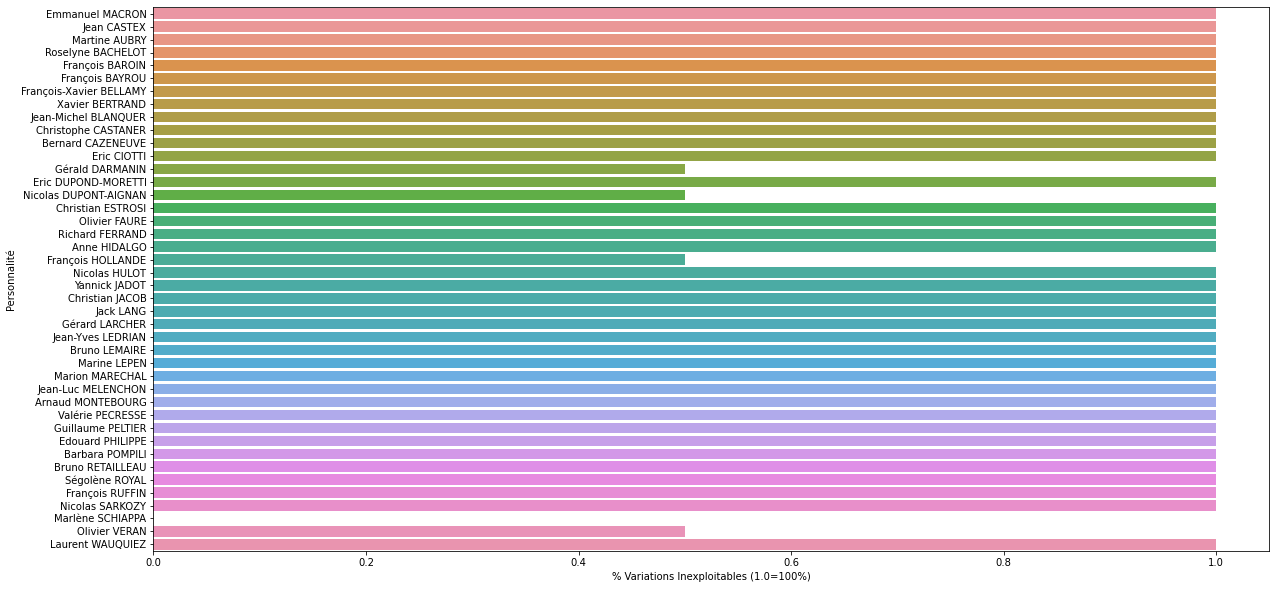

In [30]:
last_inex_ens=last_inex[last_inex.Categorie=='ENSEMBLE']
fig = plt.figure(figsize=(20,10))
ax=sns.barplot(x='Inexploitable',y='Nom',data=last_inex_ens,ci=None
#  ,estimator=lambda x: len(x) / len(df_inex[df_inex.Categorie=='ENSEMBLE']) * 100
)
ax.set(xlabel="% Variations Inexploitables (1.0=100%)")
ax.set(ylabel="Personnalité ")
# ax.yaxis.set_major_locator(ticker.MultipleLocator(2))

fig.savefig('plot.png')

In [31]:
print(last_inex_ens['Inexploitable'].value_counts()/len(last_inex_ens))
print(last_inex_ens['Inexploitable'].value_counts())

True     0.928571
False    0.071429
Name: Inexploitable, dtype: float64
True     78
False     6
Name: Inexploitable, dtype: int64


In [64]:
nom='SCHIA'
categorie='Proximitépolitique'
last_inex[(last_inex.Nom.str.contains(nom))&(last_inex.Inexploitable==False)]

,Résultats,Categorie,Groupe,Inexploitable,Nom
2730,20.1,ENSEMBLE,ENSEMBLE,False,Marlène SCHIAPPA
2731,18.9,Sexe,Homme,False,Marlène SCHIAPPA
2733,16.6,Age,18à24ans,False,Marlène SCHIAPPA
2740,16.2,Age,ST35à59ans,False,Marlène SCHIAPPA
2763,19.6,Région,STProvince,False,Marlène SCHIAPPA
2766,11.5,Catégoried'agglomération,20.000à100.000hab,False,Marlène SCHIAPPA
2769,7.8,Revenumensuelnetdufoyer,Moinsde1.200€,False,Marlène SCHIAPPA
2773,12.1,Diplômeleplusélevé,InférieurauBAC,False,Marlène SCHIAPPA
2776,7.1,Proximitépolitique,STFIPdGPC,False,Marlène SCHIAPPA
2779,47.6,Proximitépolitique,LREM,False,Marlène SCHIAPPA


In [49]:
last_inex.Categorie.unique()

array(['ENSEMBLE', 'Sexe', 'Age', 'PCSdelapersonnederéférencedufoyer',
       "PCSdel'individu", 'Région', "Catégoried'agglomération",
       'Revenumensuelnetdufoyer', 'Diplômeleplusélevé',
       'Proximitépolitique', 'VotePrésidentielle20171ertour',
       'VotePrésidentielle20172ndtour'], dtype=object)

## Variation d'une personnalité sur les deux derniers jeux de données

In [32]:
nom="Emmanuel MACRON"
short_d=data_f[(data_f.Nom==nom) & ((data_f.Date==most_recent) | (data_f.Date==scd_most_recent)) & (data_f.Groupe=='Rural')].sort_values(by='Date',ascending=True,ignore_index=True)
print('Favorable')
print((margin_p(short_d['ST Favorable']/100,short_d.Base)*100).T)
print('Défavorable')
print((margin_p(short_d['ST Défavorable']/100,short_d.Base)*100).T)
short_d

Favorable
[[25.38874416 37.41125584]
 [28.05581435 40.34418565]]
Défavorable
[[57.05728918 69.54271082]
 [53.75747754 66.44252246]]


,Nom,Categorie,Groupe,Base,Très favorable,Plutôt favorable,ST Favorable,Plutôt défavorable,Très défavorable,ST Défavorable,Nsp,Evolution ST Favorable,Evolution ST Défavorable,Date,Inexploitable Favorable,Inexploitable Défavorable,Erreur Th Favorable,Erreur Th Défavorable
0,Emmanuel MACRON,Catégoried'agglomération,Rural,229.0,8.4,23.0,31.4,28.0,35.2,63.3,5.4,4.1,-1.3,2020-12-12,True,True,6.011256,6.242711
1,Emmanuel MACRON,Catégoried'agglomération,Rural,229.0,8.0,26.2,34.2,33.2,26.9,60.1,5.7,2.8,-3.2,2021-01-22,True,True,6.144186,6.342522


In [33]:
data_f[(data_f.Nom==nom) & (data_f.Date==most_recent) & (data_f['Inexploitable Favorable']==False)]

,Nom,Categorie,Groupe,Base,Très favorable,Plutôt favorable,ST Favorable,Plutôt défavorable,Très défavorable,ST Défavorable,Nsp,Evolution ST Favorable,Evolution ST Défavorable,Date,Inexploitable Favorable,Inexploitable Défavorable,Erreur Th Favorable,Erreur Th Défavorable
30,Emmanuel MACRON,Région,Nord-Est,225.0,7.1,21.5,28.6,33.8,30.4,64.2,7.1,-14.9,12.2,2021-01-22,False,True,5.904688,6.264319
43,Emmanuel MACRON,Diplômeleplusélevé,InférieurauBAC,400.0,5.5,23.8,29.3,28.9,36.3,65.2,5.5,-9.6,8.7,2021-01-22,False,True,4.460357,4.668093


# Dernière variation observable

In [34]:


def find_last_var(df):
    last_var={}
    for nom in df.Nom.unique():
        last_var[nom]={'fav':None,'defav':None,'date_fav':None,'date_defav':None}
        df_var=df[(df.Nom==nom) & (df.Categorie=='ENSEMBLE')]
        df_var=df_var.sort_values(by='Date',ascending=False,ignore_index=True)
        l_base=df_var.iloc[0].Base
        l_fav=df_var.iloc[0]['ST Favorable']
        l_defav=df_var.iloc[0]['ST Défavorable']
        er_l_fav=error_p(l_fav/100,l_base)*100
        er_l_defav=error_p(l_defav/100,l_base)*100
        for i in range(1,len(df_var)):
            t=df_var.iloc[i]
            t_base=t.Base
            t_fav=t['ST Favorable']
            t_defav=t['ST Défavorable']
            er_t_fav=error_p(t_fav/100,t_base)*100
            er_t_defav=error_p(t_defav/100,t_base)*100
            # print(l_fav,er_l_fav,t_fav,er_t_fav)
            if l_fav+er_l_fav < t_fav-er_t_fav and last_var[nom]['fav']==None:
                last_var[nom]['fav']= t_fav-er_t_fav-(l_fav+er_l_fav)
                last_var[nom]['date_fav']= t.Date                
            elif l_fav-er_l_fav > t_fav+er_t_fav and last_var[nom]['fav']==None:
                last_var[nom]['fav']= l_fav+er_l_fav-(t_fav-er_t_fav)
                last_var[nom]['date_fav']= t.Date                
            if l_defav+er_l_defav < t_defav-er_t_defav and last_var[nom]['defav']==None:
                last_var[nom]['defav']= t_defav-er_t_defav-(l_defav+er_l_defav)
                last_var[nom]['date_defav']= t.Date                
            elif l_defav-er_l_defav > t_defav+er_t_defav and last_var[nom]['defav']==None:
                last_var[nom]['defav']= l_defav+er_l_defav-(t_defav-er_t_defav)
                last_var[nom]['date_defav']= t.Date                
    return last_var

In [44]:
nom='Emmanuel MACRON'
last_var=find_last_var(data_f)
last_var[nom] 

{'fav': 3.0636585182615264,
 'defav': 15.138883622445704,
 'date_fav': Timestamp('2020-03-20 00:00:00'),
 'date_defav': Timestamp('2020-03-20 00:00:00')}

In [36]:
def find_last_var_usable(df):
    cols=['Nom','VarFav','DateFav','VarDefav','DateDefav']
    last_var=pd.DataFrame(columns=cols)
    for nom in df.Nom.unique():   
        t_uple=[nom]
        c_df=df.loc[(df.Nom==nom) & (df['Inexploitable Favorable']==False) & (df['Evolution ST Favorable']!=0)].sort_values(by=['Date'],ascending=False)
        if not c_df.empty:
            dernier_val=c_df.iloc[0]
            t_uple.append(dernier_val['Evolution ST Favorable'])
            t_uple.append(dernier_val['Date'])
        else:
            t_uple.extend([np.nan,np.nan])
            
        c_df=df.loc[(df.Nom==nom) & (df['Inexploitable Défavorable']==False) & (df['Evolution ST Défavorable']!=0)].sort_values(by=['Date'],ascending=False)
        if not c_df.empty:
            dernier_val=c_df.iloc[0]
            t_uple.append(dernier_val['Evolution ST Défavorable'])
            t_uple.append(dernier_val['Date'])
        else:
            t_uple.extend([np.nan,np.nan])
        last_var=last_var.append(pd.Series(t_uple, index=cols),ignore_index=True)
    return last_var


In [37]:
find_last_var_usable(data_f[data_f.Categorie=='ENSEMBLE'])

,Nom,VarFav,DateFav,VarDefav,DateDefav
0,Emmanuel MACRON,-6.1,2020-04-24,7.2,2020-04-24 00:00:00
1,Edouard PHILIPPE,12.9,2020-03-20,-11.7,2020-03-20 00:00:00
2,Martine AUBRY,NaN,NaT,NaN,NaT
3,François BAROIN,NaN,NaT,NaN,NaT
4,François BAYROU,NaN,NaT,NaN,NaT
5,Xavier BERTRAND,5.9,2020-03-20,6.9,2020-09-05 00:00:00
6,Jean-Michel BLANQUER,12.2,2020-03-20,-7.0,2020-07-18 00:00:00
7,Agnès BUZYN,-4.8,2020-04-24,8.0,2020-03-20 00:00:00
8,Christophe CASTANER,-6.2,2020-07-18,-6.0,2020-03-20 00:00:00
9,Eric CIOTTI,NaN,NaT,NaN,NaT


## Verification pas de données bizarre

In [38]:
data_f[data_f.Base==0]



,Nom,Categorie,Groupe,Base,Très favorable,Plutôt favorable,ST Favorable,Plutôt défavorable,Très défavorable,ST Défavorable,Nsp,Evolution ST Favorable,Evolution ST Défavorable,Date,Inexploitable Favorable,Inexploitable Défavorable,Erreur Th Favorable,Erreur Th Défavorable
12,Emmanuel MACRON,PCSdelapersonnederéférencedufoyer,Agriculteur exploitant,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-12-08,False,False,NaN,NaN
82,Edouard PHILIPPE,PCSdelapersonnederéférencedufoyer,Agriculteur exploitant,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-12-08,False,False,NaN,NaN
152,Martine AUBRY,PCSdelapersonnederéférencedufoyer,Agriculteur exploitant,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-12-08,False,False,NaN,NaN
222,François BAROIN,PCSdelapersonnederéférencedufoyer,Agriculteur exploitant,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-12-08,False,False,NaN,NaN
292,François BAYROU,PCSdelapersonnederéférencedufoyer,Agriculteur exploitant,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-12-08,False,False,NaN,NaN
362,Xavier BERTRAND,PCSdelapersonnederéférencedufoyer,Agriculteur exploitant,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-12-08,False,False,NaN,NaN
432,Jean-Michel BLANQUER,PCSdelapersonnederéférencedufoyer,Agriculteur exploitant,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-12-08,False,False,NaN,NaN
502,Agnès BUZYN,PCSdelapersonnederéférencedufoyer,Agriculteur exploitant,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-12-08,False,False,NaN,NaN
572,Christophe CASTANER,PCSdelapersonnederéférencedufoyer,Agriculteur exploitant,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-12-08,False,False,NaN,NaN
642,Eric CIOTTI,PCSdelapersonnederéférencedufoyer,Agriculteur exploitant,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-12-08,False,False,NaN,NaN


In [39]:
favUnmatch=data_f[np.abs(data_f['Très favorable']+data_f['Plutôt favorable']-data_f['ST Favorable'])>0.11]
favUnmatch

,Nom,Categorie,Groupe,Base,Très favorable,Plutôt favorable,ST Favorable,Plutôt défavorable,Très défavorable,ST Défavorable,Nsp,Evolution ST Favorable,Evolution ST Défavorable,Date,Inexploitable Favorable,Inexploitable Défavorable,Erreur Th Favorable,Erreur Th Défavorable


In [40]:
defavUnmatch=data_f[np.abs(data_f['Très défavorable']+data_f['Plutôt défavorable']-data_f['ST Défavorable'])>0.11]
defavUnmatch

,Nom,Categorie,Groupe,Base,Très favorable,Plutôt favorable,ST Favorable,Plutôt défavorable,Très défavorable,ST Défavorable,Nsp,Evolution ST Favorable,Evolution ST Défavorable,Date,Inexploitable Favorable,Inexploitable Défavorable,Erreur Th Favorable,Erreur Th Défavorable


In [41]:
unmatch=data_f[np.abs(data_f['ST Favorable']+data_f['ST Défavorable']+data_f['Nsp'])<99.89]
unmatch



,Nom,Categorie,Groupe,Base,Très favorable,Plutôt favorable,ST Favorable,Plutôt défavorable,Très défavorable,ST Défavorable,Nsp,Evolution ST Favorable,Evolution ST Défavorable,Date,Inexploitable Favorable,Inexploitable Défavorable,Erreur Th Favorable,Erreur Th Défavorable
12,Emmanuel MACRON,PCSdelapersonnederéférencedufoyer,Agriculteur exploitant,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-12-08,False,False,NaN,NaN
82,Edouard PHILIPPE,PCSdelapersonnederéférencedufoyer,Agriculteur exploitant,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-12-08,False,False,NaN,NaN
152,Martine AUBRY,PCSdelapersonnederéférencedufoyer,Agriculteur exploitant,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-12-08,False,False,NaN,NaN
222,François BAROIN,PCSdelapersonnederéférencedufoyer,Agriculteur exploitant,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-12-08,False,False,NaN,NaN
292,François BAYROU,PCSdelapersonnederéférencedufoyer,Agriculteur exploitant,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-12-08,False,False,NaN,NaN
362,Xavier BERTRAND,PCSdelapersonnederéférencedufoyer,Agriculteur exploitant,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-12-08,False,False,NaN,NaN
432,Jean-Michel BLANQUER,PCSdelapersonnederéférencedufoyer,Agriculteur exploitant,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-12-08,False,False,NaN,NaN
502,Agnès BUZYN,PCSdelapersonnederéférencedufoyer,Agriculteur exploitant,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-12-08,False,False,NaN,NaN
572,Christophe CASTANER,PCSdelapersonnederéférencedufoyer,Agriculteur exploitant,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-12-08,False,False,NaN,NaN
642,Eric CIOTTI,PCSdelapersonnederéférencedufoyer,Agriculteur exploitant,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-12-08,False,False,NaN,NaN


In [42]:
dates=np.sort(data_f.Date.unique())
last_date=dates[len(dates)-1]
prev_date=dates[len(dates)-2]
l_data=data_f[data_f.Date==last_date]
p_data=data_f[data_f.Date==prev_date]
l_noms=np.sort(l_data.Nom.unique())
p_noms=np.sort(p_data.Nom.unique())


for nom in l_noms:
    if nom in p_noms:
        lastd=l_data[l_data.Nom==nom]
        prevd=p_data[p_data.Nom==nom]
        lastd['Prev_calc']=lastd['ST Favorable']-lastd['Evolution ST Favorable']
        # check_cond=(l_data.Nom==p_data.Nom) & (l_data.Categorie==p_data.Categorie) & (l_data.Groupe==p_data.Groupe)
        lastd['Prev']= prevd['ST Favorable']
        weird=lastd[np.abs(lastd['Prev'] - lastd['Prev_calc'])> 0.11]
        if len(weird)>0:
            weird
        else:
            print('{} is clear'.format(nom))


Anne HIDALGO is clear
Arnaud MONTEBOURG is clear
Barbara POMPILI is clear
Bruno LEMAIRE is clear
Christian ESTROSI is clear
Christian JACOB is clear
Christophe CASTANER is clear
Edouard PHILIPPE is clear
Emmanuel MACRON is clear
Eric CIOTTI is clear
Eric DUPOND-MORETTI is clear
François BAROIN is clear
François BAYROU is clear
François HOLLANDE is clear
François RUFFIN is clear
Gérald DARMANIN is clear
Gérard LARCHER is clear
Jack LANG is clear
Jean CASTEX is clear
Jean-Michel BLANQUER is clear
Jean-Yves LEDRIAN is clear
Laurent WAUQUIEZ is clear
Marine LEPEN is clear
Marlène SCHIAPPA is clear
Martine AUBRY is clear
Nicolas DUPONT-AIGNAN is clear
Nicolas HULOT is clear
Nicolas SARKOZY is clear
Olivier VERAN is clear
Richard FERRAND is clear
Valérie PECRESSE is clear
Xavier BERTRAND is clear
Yannick JADOT is clear


In [43]:
for i in weird.index:
    print(p_data.loc[i ])